In [27]:
import os, re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [29]:
!pip install transformers tika yake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
cd drive/MyDrive/CYsyphus/indexed_corpus

[Errno 2] No such file or directory: 'drive/MyDrive/CYsyphus/indexed_corpus'
/content/drive/.shortcut-targets-by-id/1X1APgHBDiD-6ucORNx5eM_SWKZYOgyvz/indexed_corpus


In [32]:
def remove_punc(pdf_content):
    punc = ['• ', '· ', '&', '~', ' o ', '\uf0a7', '\uf03c', '\uf0b7', 
            '–', '()', '[…]', '| ', '© ', '(Insert Scale)', '_', '%', '[', ']', 'Ü ']
    for p in punc:
        pdf_content = pdf_content.replace(p, '')
    return pdf_content

def remove_bulleted_points(pdf_content):
    pdf_content = re.sub(r'\.+ [0-9]+', '.', pdf_content)
    pdf_content = re.sub(r'\.+[0-9]+', '.', pdf_content)
    pdf_content = re.sub(r'\.+', '.', pdf_content)

    pdf_content = re.sub(r'\([0-9]+\)', '', pdf_content)
    pdf_content = re.sub(r'[0-9]+\)', '', pdf_content)
    pdf_content = re.sub(r'[0-9]+.', '', pdf_content)
    pdf_content = re.sub(r'\([a-zA-Z]\)', '', pdf_content)
    pdf_content = re.sub(r' [a-zA-Z]\)', '', pdf_content)
    pdf_content = re.sub(r'\(i+\)', '', pdf_content)
    pdf_content = re.sub(r' i+\)', '', pdf_content)

    pdf_content = re.sub('\s\s+', ' ', pdf_content)
    return pdf_content

def remove_url(pdf_content):
    url = re.findall('http[s]?://\S+', pdf_content)
    for u in url:
        pdf_content = pdf_content.replace(u, '')
    url = re.findall('www.\S+', pdf_content)
    for u in url:
        pdf_content = pdf_content.replace(u, '')
    pdf_content = re.sub(r'http[s]?://', '', pdf_content)
    return pdf_content

def filter_sentences_by_length(pdf_sentence):
    return [s for s in pdf_sentence if len(word_tokenize(s)) > 4 and len(word_tokenize(s)) < 200]

In [33]:
from tika import parser

sentences = []

for i in range(1, 16):
    
    pdf_path = str(i) + ".pdf"
    parsed_pdf = parser.from_file(pdf_path)

    pdf_content = parsed_pdf['content'].replace('\n', ' ').replace(';', '.').strip()
    pdf_content = remove_punc(pdf_content)
    pdf_content = remove_bulleted_points(pdf_content)
    pdf_content = remove_url(pdf_content)
    pdf_content = remove_punc(pdf_content)
    pdf_content = re.sub(r'\.+', '.', pdf_content)
    pdf_content = re.sub(r'\s\s+', ' ', pdf_content)
    
    pdf_sentence = sent_tokenize(pdf_content)
    filtered_sentence = filter_sentences_by_length(pdf_sentence)
    sentences += filtered_sentence

len(sentences)

13667

In [34]:
# # Extract Keywords

# import yake

# language = "en"
# max_ngram_size = 2 
# deduplication_threshold = 0.3
# numOfKeywords = 50

# custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
# keywords_tuple = custom_kw_extractor.extract_keywords(' '.join(sentences))
# keywords_list = [word.lower() for word, score in keywords_tuple]

In [35]:
# # Filter Sentence with KWs

# lem = WordNetLemmatizer()
# sentences_with_kw = []

# for sent in sentences:
#     lem_sent = lem.lemmatize(sent)
#     lem_sent = lem_sent.lower()
#     if any(kw in lem_sent for kw in keywords_list):
#         sentences_with_kw.append(sent)

# len(sentences_with_kw)

In [36]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

inputs = tokenizer(
    sentences, 
    max_length=100, 
    truncation=True, 
    padding='max_length', 
    return_tensors='tf'
)

inputs['labels'] = inputs['input_ids']
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [37]:
import numpy as np

inp_ids, inp_masks, inp_labels = [], [], []

inp_ids_numpy = inputs.input_ids.numpy()
inp_masks_numpy = inputs.attention_mask.numpy()
inp_labels_numpy = inputs.labels.numpy()
input_len = len(inp_ids_numpy)

# Get the token set of our corpus
token_set, _ = tf.unique(tf.reshape(inp_ids_numpy, [-1]))
token_set = token_set.numpy()
special_token = np.array([0, 101, 102, 103])
candidate_token = np.setdiff1d(token_set, special_token)

for idx in range(input_len):
    inp, msk, lbl = inp_ids_numpy[idx], inp_masks_numpy[idx], inp_labels_numpy[idx]
    actual_tokens = list(set(range(len(inp))) - set(np.where((inp == 101) | (inp == 102) | (inp == 0))[0].tolist()))
        
    # Select 15% random tokens from the given list
    num_of_token_to_mask = max(1, int(len(actual_tokens) * 0.15))
    token_to_mask = np.random.choice(np.array(actual_tokens), size=num_of_token_to_mask, replace=False).tolist()
    
    # Tell the model where the tokens are masked
    msk[token_to_mask] = 0
    inp_masks.append(msk)

    # Set the labels for the unmasked tokens to -100
    unmasked_indices = np.setdiff1d(np.arange(len(inp)), token_to_mask)
    lbl[unmasked_indices] = -100
    inp_labels.append(lbl)

    # Mask the tokens with [MASK] (80%) / random word (10%) / same word (10%)
    for tk in token_to_mask:
        prob = np.random.rand()
        if prob < 0.8:
            inp[tk] = 103  # 80% [MASK]
        elif prob < 0.9:
            inp[tk] = np.random.choice(candidate_token)  # 10% Random Word
    inp_ids.append(inp)

inputs['input_ids'] = tf.convert_to_tensor(np.asarray(inp_ids))
inputs['attention_mask'] = tf.convert_to_tensor(np.asarray(inp_masks))
inputs['labels'] = tf.convert_to_tensor(np.asarray(inp_labels))

In [38]:
print(inputs['input_ids'][0])
print(inputs['attention_mask'][0])
print(inputs['labels'][0])

tf.Tensor(
[  101  2473   103  1996  2307  2103  2816  2013   103  7339  1997  2266
  4733   103  1011  3036  1999   103  1521   103  1047  1011  4044  2473
  1997   103  2307  2103  2816  2013   103  7339  1997  2266  4733 16941
  1011  3036  1999  2651  1521  1055  1047  1011  4044  2011  2266  4733
  1997  1996  2473  1997   103  2307  2103  2816 16941  1011  3036   103
  2651  1521  1055   103  1011  4044   103  1996  2473  1997  1996  2307
  2103  2816  1996  2473  1997  1996  2307  2103  2816  2003  1996  2069
  2120  3029  7580  5052   103  3791  1997  3923  2270  1011  2082  4733
  1012   102     0     0], shape=(100,), dtype=int32)
tf.Tensor(
[1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0], shape=(100,), dtype=int32)
tf.Tensor(
[ -100  -100  1997  1996  -100  -100  -100  -100  1996  -100  -100  -100
  -100 16941  -100  -100

In [39]:
split_ratio = 0.1
data_size = len(inputs['input_ids'])
val_size = int(split_ratio * data_size)
train_size = data_size - val_size

arr = np.arange(data_size)
val_indices = np.random.choice(arr, size=val_size, replace=False)
train_indices = np.delete(arr, val_indices)

val_indices, train_indices = tf.convert_to_tensor(val_indices), tf.convert_to_tensor(train_indices)

In [40]:
train_input_ids = tf.convert_to_tensor(np.array(inputs.input_ids)[train_indices])
train_attention_mask = tf.convert_to_tensor(np.array(inputs.attention_mask)[train_indices])
train_labels = tf.convert_to_tensor(np.array(inputs.labels)[train_indices])

val_input_ids = tf.convert_to_tensor(np.array(inputs.input_ids)[val_indices])
val_attention_mask = tf.convert_to_tensor(np.array(inputs.attention_mask)[val_indices])
val_labels = tf.convert_to_tensor(np.array(inputs.labels)[val_indices])

print("train inputs shape:", train_input_ids.shape)
print("val inputs shape:", val_input_ids.shape)
print("train labels shape:", train_labels.shape)
print("val labels shape:", val_labels.shape)

train inputs shape: (12301, 100)
val inputs shape: (1366, 100)
train labels shape: (12301, 100)
val labels shape: (1366, 100)


In [41]:
from transformers import TFBertForMaskedLM, BertConfig

# # Create a new configuration object
# model_config = BertConfig.from_pretrained('bert-base-uncased')

# # Modify the number of attention heads, hidden layers, etc.
# model_config.num_attention_heads = 6   # Default is 12
# model_config.num_hidden_layers = 6     # Default is 12
# model_config.hidden_size = 600         # Default is 768
# model_config.hidden_dropout_prob = 0.2 # Default is 0.1

# # Create a new BERT model with the modified configuration
# model = TFBertForMaskedLM(model_config)

model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')
# model.summary()

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [42]:
# # Freeze all TFBertLayer except the last one
# for layer in model.bert.encoder.layer[:-2]:
#     layer.trainable = False

# # Unfreeze the last TFBertLayer
# for layer in model.bert.encoder.layer[-2:]:
#     layer.trainable = True
#     # for variable in layer.trainable_variables:
#     #     variable._trainable = True

In [43]:
model.bert.embeddings.trainable = False

unfreeze_layer_count = 6
for layer in model.bert.encoder.layer[:-unfreeze_layer_count]:
    layer.trainable = False

In [44]:
print(model.bert.embeddings.trainable, '\n')

for layer in model.bert.encoder.layer:
    print(layer.trainable)

model.summary()

False 

False
False
False
False
False
False
True
True
True
True
True
True
Model: "tf_bert_for_masked_lm_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 mlm___cls (TFBertMLMHead)   multiple                  24459834  
                                                                 
Total params: 109,514,298
Trainable params: 43,149,882
Non-trainable params: 66,364,416
_________________________________________________________________


In [45]:
epochs = 10
batch_size = 32

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=-100)
    )

history = model.fit(
    [train_input_ids, train_attention_mask], 
    train_labels, 
    verbose=1, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=([val_input_ids, val_attention_mask], val_labels)
    )

Epoch 1/10
385/385 [==============================] - 251s 570ms/step - loss: 3.0495 - val_loss: 2.7709
Epoch 2/10
385/385 [==============================] - 214s 555ms/step - loss: 2.3441 - val_loss: 2.7130
Epoch 3/10
385/385 [==============================] - 223s 579ms/step - loss: 1.7942 - val_loss: 2.7823
Epoch 4/10
385/385 [==============================] - 222s 577ms/step - loss: 1.3165 - val_loss: 2.8796
Epoch 5/10
385/385 [==============================] - 222s 578ms/step - loss: 0.9472 - val_loss: 2.9125
Epoch 6/10
385/385 [==============================] - 222s 577ms/step - loss: 0.6814 - val_loss: 2.9694
Epoch 7/10
385/385 [==============================] - 222s 578ms/step - loss: 0.5056 - val_loss: 3.0391
Epoch 8/10
385/385 [==============================] - 213s 555ms/step - loss: 0.3964 - val_loss: 3.0491
Epoch 9/10
385/385 [==============================] - 214s 555ms/step - loss: 0.3318 - val_loss: 3.0620
Epoch 10/10
385/385 [==============================] - 222s 577m

In [46]:
original_model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')
print('\nOriginal Model Params:', original_model.count_params())
print('Fine-Tuned Model Params:', model.count_params())

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.



Original Model Params: 109514298
Fine-Tuned Model Params: 109514298


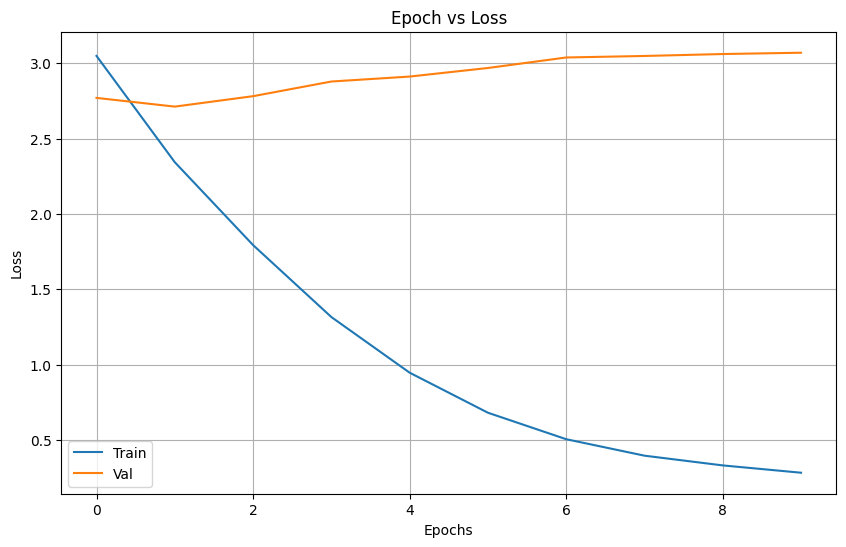

In [47]:
train_losses = history.history['loss']
val_losses = history.history['val_loss']

plt.figure(figsize=(10, 6))

plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(train_losses)), val_losses, label='Val')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()

plt.show()

In [48]:
model.save_weights(f'/content/drive/MyDrive/frz_layer_{unfreeze_layer_count}.h5')

In [49]:
input_ids = tokenizer("Hello, my dog is cute", return_tensors="tf")["input_ids"]
input_ids

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]],
      dtype=int32)>

In [50]:
outputs = model(input_ids, labels=input_ids, output_hidden_states=True)
model_output = outputs[2][12]
model_output.shape

TensorShape([1, 8, 768])

In [51]:
outputs = original_model(input_ids, labels=input_ids, output_hidden_states=True)
original_output = outputs[2][12]
original_output.shape

TensorShape([1, 8, 768])

In [52]:
tf.math.reduce_all(tf.math.equal(model_output, original_output))

<tf.Tensor: shape=(), dtype=bool, numpy=False>